# Parallelism Demo

Consider a function, $f$,

$$f(t) = \sum_{k\in\mathbb{N}}^{\infty}(-1)^k\dfrac{\sin[(2k+1) x]}{(2k+1)^2}$$

<img src='images/fourier.jpeg' width=150 style="display:block;margin-left:auto;margin-right:auto;width:50%;"/>

> All vibes may be approximated by harmonic oscillators

In [1]:
from plt_style import *
#import numpy as np
import cupy  as np
import pylab as plt
import scipy as sp
%config InlineBackend.figure_format = 'retina'

In [2]:
!nvidia-smi
!nvidia-smi -L

Tue Apr 18 10:52:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:C1:00.0 Off |                    0 |
| N/A   26C    P0    58W / 500W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
N = 10**7 #2**26+1
#N = int(32e6)
#N = 2**26+1
M = N-1
t = np.linspace(0,10*np.pi,N)[:-1]


In [4]:
f = 0*t
num_modes = 31
for k in range(num_modes):
    ell = 2*k+1
    f += (-1)**k*np.sin(ell*t)/ell**2

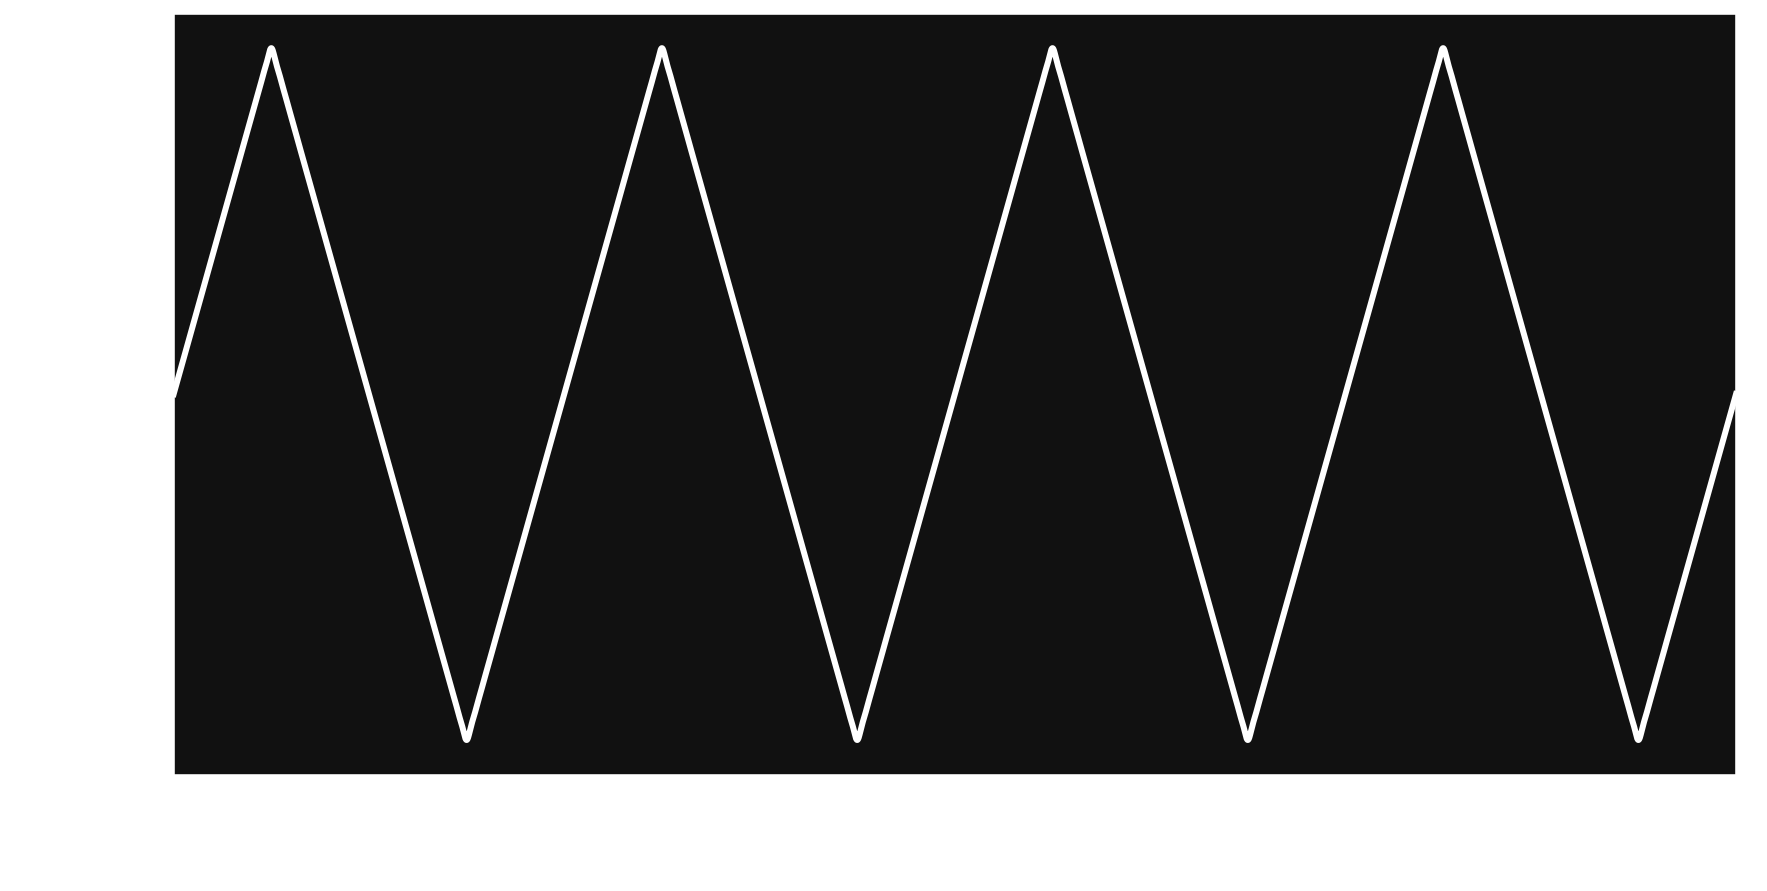

In [5]:
skip = 1 if len(t) < 2**20 else 1000
ts,fs= [ np.asnumpy(u)[::skip] for u in [t,f] ]
plt.figure(figsize=(14,7))
plt.plot(ts,fs,'w-',lw=3)
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$t$',fontsize=20,color='w')
_=plt.ylabel(r'$f(t)$',fontsize=20,color='w')
_=plt.xlim(0,4*2*np.pi)

In [6]:
%%time
q = np.abs(np.fft.fft(f)[:M//2])

CPU times: user 25.9 ms, sys: 15.8 ms, total: 41.7 ms
Wall time: 146 ms


In [7]:
tau = 10*np.pi
om0 = 2*np.pi/tau
om  = om0*np.asnumpy(np.arange(len(q)))
p   = np.asnumpy(q)
p  /= p.max()
k   = np.asnumpy(np.linspace(1,11,1001))

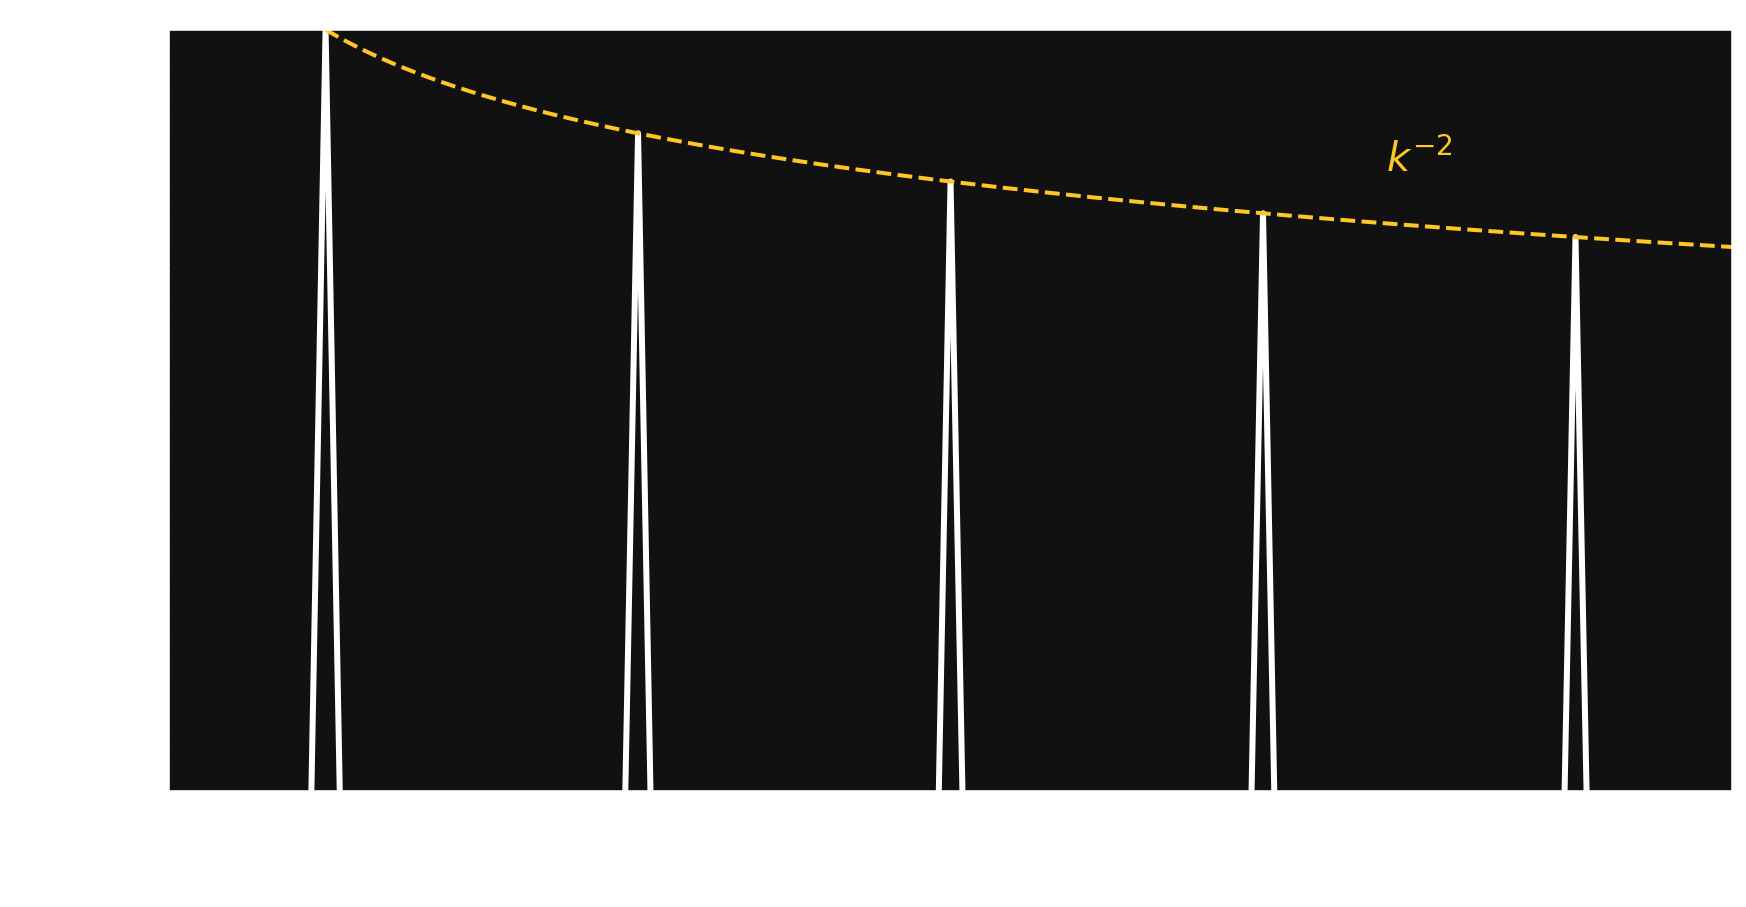

In [8]:
plt.figure(figsize=(14,7))
plt.semilogy(om,p,'w-',lw=3)
plt.semilogy(k,1/k**2,'--',c=gld,lw=2)
plt.annotate(r'$k^{-2}$',(8,5e-2),fontsize=20,color=gld,ha='center')
_=plt.xlim(0,10)
_=plt.ylim(1e-7,1)
_=plt.xticks(np.asnumpy(np.arange(10)),fontsize=20)
_=plt.yticks(fontsize=20)
_=plt.xlabel(r'$\omega$',fontsize=20,color='w')
_=plt.ylabel(r'$PSD$',fontsize=20,color='w')

## Einsum on the GPU

Consider 

$$U(x,y,z) = \sum_{\ell\in\mathbb{N}\,odd}^{\infty}\dfrac{\cos(\ell x)\sin(\ell z)}{\ell^3}$$

for $(x,y,z)\in[0,\pi]^3$. Then, in the $xz$-plane, $\partial U/\partial x$ is the cartesian product of two orthogonal triangle waves.

In [ ]:
import cheb
import numpy as onp

In [ ]:
N = 256
Do,xo = cheb.cheb(256)
D,x = Do*2/np.pi,(xo+1)*np.pi/2
sanity = np.isclose( (D@x).sum()/(N+1),1)
print(f"Sanity: {sanity.__repr__():s}")
Dgpu,xgpu = np.array(D),np.array(x)

In [ ]:
X,Y,Z = onp.meshgrid(x,x,x,indexing='ij')
U = onp.array([ onp.cos(ell*X)*onp.sin(ell*Z)/ell**3 for ell in 2*onp.arange(31)+1 ]).sum(axis=0)

In [ ]:
Ugpu = np.array(U)

In [ ]:
%%time
dUdx = np.einsum('ij,jkl->ikl',Dgpu,Ugpu)

In [ ]:
dUdx_iter = 0*dUdx

In [ ]:
%%time
for k in range(Ugpu.shape[-1]):
    dUdx_iter[:,:,k] = Dgpu @ Ugpu[:,:,k]

In [ ]:
dUdx = np.asnumpy(dUdx)

In [ ]:
import hellaPy
f,a = hellaPy.no_ax_fax()
L   = onp.abs(dUdx).max() * onp.linspace(-1,1,16)
hellaPy.mycontourf(X[:,128,:],Z[:,128,:],dUdx[:,128,:],L,cmap=hellaPy.mycm15)